In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
import metrics


In [3]:
animal_data = pd.read_csv("animal_data_clean.csv")
animal_data.head()

,Group,A_C1W1T0,A_C2W1T0,L_C1W1T0,L_C2W1T0,A_C1W2T0,A_C2W2T0,L_C1W2T0,L_C2W2T0,A_C1W3T0,...,rC_C2W3T2,lC_C2W4T2,cC_C2W4T2,rC_C2W4T2,lC_C2W5T2,cC_C2W5T2,rC_C2W5T2,Level_70_70,Level_70_90,Level_90_90
0,0,0.000002,0.000003,1.352459,11.270492,0.000005,0.000006,2.090164,12.008197,0.000004,...,0.000258,0.000033,0.000092,0.000078,0.000058,0.000031,0.000016,True,False,False
1,0,0.000002,0.000005,1.311475,11.188525,0.000005,0.000008,2.008197,11.885246,0.000004,...,0.000228,0.000090,0.000122,0.000080,0.000059,0.000041,0.000010,False,True,False
2,0,0.000004,0.000004,1.311475,11.229508,0.000008,0.000008,2.049180,12.008197,0.000006,...,0.000209,0.000104,0.000096,0.000037,0.000078,0.000073,0.000030,False,False,True
3,0,0.000006,0.000006,1.352459,11.270492,0.000005,0.000006,2.131148,12.049180,0.000004,...,0.000091,0.000044,0.000081,0.000074,0.000026,0.000055,0.000030,True,False,False
4,0,0.000005,0.000010,1.311475,11.188525,0.000006,0.000008,2.049180,11.926230,0.000004,...,0.000140,0.000084,0.000098,0.000063,0.000033,0.000022,0.000017,False,True,False


In [4]:
Y = animal_data['Group']
X = animal_data.drop(['Group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [5]:
zscore_scaler = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_normalized = X_train.copy()  
X_train_normalized[numeric_columns] = zscore_scaler.fit_transform(X_train[numeric_columns])

# Transform the testing data using the same scaler to avoid data leakage
X_test_normalized = X_test.copy()  
X_test_normalized[numeric_columns] = zscore_scaler.transform(X_test[numeric_columns])

In [6]:
skf = StratifiedKFold(n_splits=5)

In [7]:
## hyperparameters
max_depths = np.arange(1,11)
criterions = ['gini','entropy','log_loss']
grid_result_list = []

In [8]:
for depth in max_depths:
    for criteria in criterions:
        grid_result = {}
        grid_result['criteria'] = criteria
        grid_result['depth'] = depth
        
        for i,(train_index,test_index) in enumerate(skf.split(X_train_normalized,y_train)):
            train_features, train_label = X_train_normalized.iloc[train_index], y_train.iloc[train_index]
            test_features, test_label = X_train_normalized.iloc[test_index], y_train.iloc[test_index]

            ## define model 
            DT_classifier = DecisionTreeClassifier(max_depth=depth,random_state=42,criterion=criteria)  ## setting the random_state for reproducability
            DT_classifier.fit(train_features,train_label)

            ypred = DT_classifier.predict(test_features)
            dt_metrics = metrics.metrics(test_label,ypred)
            precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
            acc = dt_metrics.compute_accuracy()

            grid_result[f'accuracy_fold{i}'] = acc
            grid_result[f'f1_scores_fold{i}'] = f1_scores
            grid_result[f'macro_f1_fold{i}'] = macro_f1
            grid_result[f'weighted_f1_fold{i}'] = weighted_f1
            
        ##compute the average values
        grid_result['avg_acc'] = 0.2*sum([grid_result[f'accuracy_fold{i}'] for i in np.arange(5)])
        grid_result['avg_weighted_f1'] = 0.2*sum([grid_result[f'weighted_f1_fold{i}'] for i in np.arange(5)])
        grid_result['avg_macro_f1'] = 0.2*sum([grid_result[f'macro_f1_fold{i}'] for i in np.arange(5)])
        grid_result_list.append(grid_result)


            

In [9]:
grid_df = pd.DataFrame(grid_result_list)
grid_df[['criteria','depth','avg_acc','avg_weighted_f1']]

,criteria,depth,avg_acc,avg_weighted_f1
0,gini,1,0.788046,0.654394
1,entropy,1,0.774483,0.632113
2,log_loss,1,0.774483,0.632113
3,gini,2,0.794713,0.668681
4,entropy,2,0.815172,0.694649
5,log_loss,2,0.815172,0.694649
6,gini,3,0.849655,0.740367
7,entropy,3,0.876782,0.774778
8,log_loss,3,0.876782,0.774778
9,gini,4,0.828966,0.703879


In [10]:
depths = ['1','2','3','4','5','6','7','8','9','10']
gini_ = grid_df[grid_df['criteria']=='gini']
gini_acc = np.array(gini_['avg_acc'])
gini_f1 = np.array(gini_['avg_weighted_f1'])
entropy_ = grid_df[grid_df['criteria']=='gini']
entropy_acc = np.array(entropy_['avg_acc'])
entropy_f1 = np.array(entropy_['avg_weighted_f1'])
log_ = grid_df[grid_df['criteria']=='log_loss']
log_acc = np.array(log_['avg_acc'])
log_f1 = np.array(log_['avg_weighted_f1'])

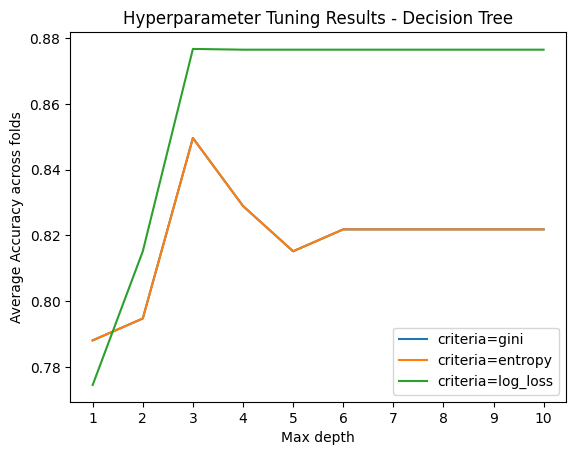

In [11]:
plt.plot(depths,gini_acc,label='criteria=gini')
plt.plot(depths,entropy_acc,label='criteria=entropy')
plt.plot(depths,log_acc,label='criteria=log_loss')
plt.xlabel('Max depth')
plt.ylabel('Average Accuracy across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - Decision Tree')
plt.show()

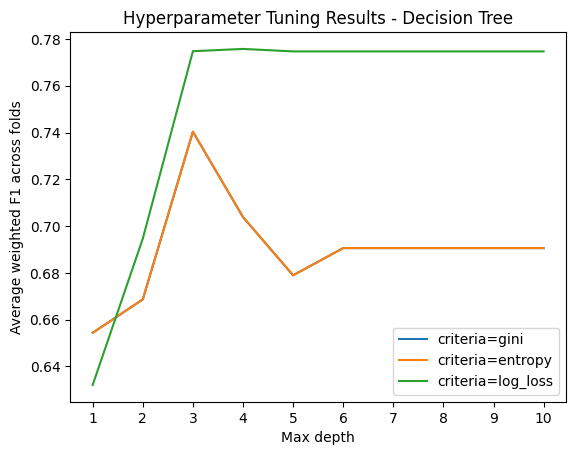

In [12]:
plt.plot(depths,gini_f1,label='criteria=gini')
plt.plot(depths,entropy_f1,label='criteria=entropy')
plt.plot(depths,log_f1,label='criteria=log_loss')
plt.xlabel('Max depth')
plt.ylabel('Average weighted F1 across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - Decision Tree')
plt.show()

In [21]:
best_dt_model = DecisionTreeClassifier(max_depth=3,random_state=42,criterion='log_loss')  ## setting the random_state for reproducability
best_dt_model.fit(X_train_normalized,y_train)

y_pred = best_dt_model.predict(X_test_normalized)
dt_metrics = metrics.metrics(y_test,y_pred)
precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
acc = dt_metrics.compute_accuracy()

In [22]:
print('\n Accuracy:',acc)
print('\n f1 scores:',f1_scores)
print('\n weighted f1-score:',weighted_f1)
print('\n precisions:',precisions)
print('\n recalls:',recalls)
print('\n macro f1:',macro_f1)


 Accuracy: 0.8648648648648649

 f1 scores: [0.8888888888888888, 0.6, 0.9285714285714286]

 weighted f1-score: 0.7592878592878594

 precisions: [0.8888888888888888, 0.75, 0.8666666666666667]

 recalls: [0.8888888888888888, 0.5, 1.0]

 macro f1: 0.8058201058201059


## INTERPRETABILITY

[Text(0.5, 0.875, 'A_C2W1T2 <= 0.391\nlog_loss = 1.355\nsamples = 146\nvalue = [72, 14, 60]'),
 Text(0.25, 0.625, 'A_C2W3T0 <= 0.179\nlog_loss = 0.713\nsamples = 62\nvalue = [9, 1, 52]'),
 Text(0.125, 0.375, 'cC_C2W3T2 <= 0.313\nlog_loss = 0.684\nsamples = 11\nvalue = [9, 0, 2]'),
 Text(0.0625, 0.125, 'log_loss = 0.0\nsamples = 9\nvalue = [9, 0, 0]'),
 Text(0.1875, 0.125, 'log_loss = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.375, 0.375, 'cC_C2W5T0 <= 0.041\nlog_loss = 0.139\nsamples = 51\nvalue = [0, 1, 50]'),
 Text(0.3125, 0.125, 'log_loss = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4375, 0.125, 'log_loss = 0.0\nsamples = 50\nvalue = [0, 0, 50]'),
 Text(0.75, 0.625, 'lC_C1W5T0 <= 0.314\nlog_loss = 1.051\nsamples = 84\nvalue = [63, 13, 8]'),
 Text(0.625, 0.375, 'A_C2W2T0 <= 0.438\nlog_loss = 1.376\nsamples = 29\nvalue = [13, 13, 3]'),
 Text(0.5625, 0.125, 'log_loss = 0.75\nsamples = 14\nvalue = [11, 0, 3]'),
 Text(0.6875, 0.125, 'log_loss = 0.567\nsamples = 15\nvalue = [2, 13

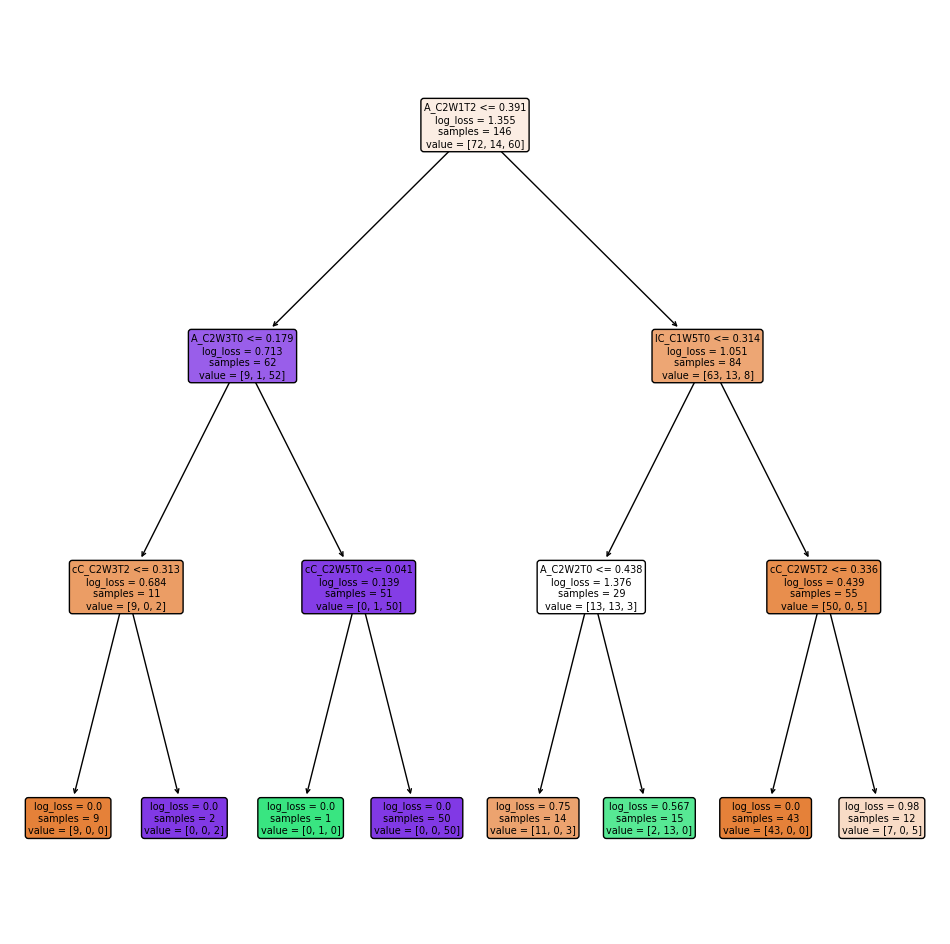

In [15]:
plt.figure(figsize=(12,12))
plot_tree(best_dt_model, filled=True, feature_names=X_test_normalized.columns, rounded=True,fontsize=7)

## VARIABLE IMPORTANCE ANALYSIS

In [62]:
## 1. USING THE FEATURE IMPORTANCE SCORE METHOD FROM THE DECISION TREE LIBRARY
features = best_dt_model.feature_names_in_
feature_importance = best_dt_model.feature_importances_
feature_imp_indices = np.argsort(feature_importance)[::-1]
features_ranked = features[feature_imp_indices]
features_ranked

array(['A_C2W1T2', 'A_C2W3T0', 'lC_C1W5T0', 'A_C2W2T0', 'cC_C2W5T2',
       'cC_C2W3T2', 'cC_C2W5T0', 'A_C1W2T0', 'cC_C1W3T0', 'lC_C1W4T0',
       'cC_C1W4T0', 'rC_C1W4T0', 'A_C2W1T0', 'cC_C1W5T0', 'rC_C1W5T0',
       'lC_C2W1T0', 'cC_C2W1T0', 'rC_C2W1T0', 'lC_C2W2T0', 'cC_C2W2T0',
       'rC_C2W2T0', 'lC_C2W3T0', 'cC_C2W3T0', 'rC_C2W3T0', 'lC_C2W4T0',
       'cC_C2W4T0', 'rC_C2W4T0', 'lC_C2W5T0', 'rC_C1W3T0', 'lC_C1W3T0',
       'L_C1W2T0', 'rC_C1W2T0', 'L_C2W2T0', 'L_C2W1T0', 'A_C1W3T0',
       'L_C1W1T0', 'L_C1W3T0', 'L_C2W3T0', 'A_C1W4T0', 'A_C2W4T0',
       'L_C1W4T0', 'L_C2W4T0', 'A_C1W5T0', 'A_C2W5T0', 'L_C1W5T0',
       'L_C2W5T0', 'lC_C1W1T0', 'cC_C1W1T0', 'rC_C1W1T0', 'rC_C2W5T0',
       'cC_C1W2T0', 'lC_C1W2T0', 'Level_90_90', 'A_C1W1T2', 'rC_C2W1T2',
       'cC_C1W3T2', 'rC_C1W3T2', 'lC_C1W4T2', 'cC_C1W4T2', 'rC_C1W4T2',
       'lC_C1W5T2', 'cC_C1W5T2', 'rC_C1W5T2', 'lC_C2W1T2', 'cC_C2W1T2',
       'lC_C2W2T2', 'Level_70_90', 'cC_C2W2T2', 'rC_C2W2T2', 'lC_C2W3T2',
       'r

In [66]:
sorted_feature_imp_scores = feature_importance[feature_imp_indices]

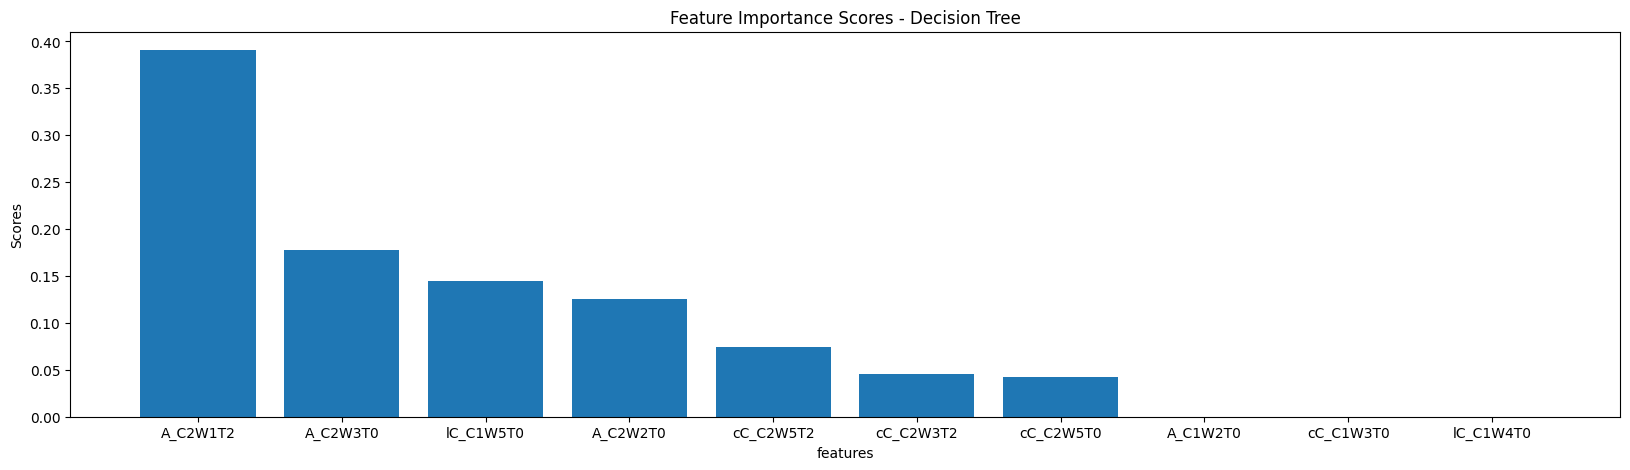

In [67]:
plt.figure(figsize=(20,5))
plt.bar(features_ranked[:10],sorted_feature_imp_scores[:10])
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Feature Importance Scores - Decision Tree')
plt.show()


In [28]:
len(features_ranked[non_zero_indices])

7

In [18]:
from sklearn.inspection import permutation_importance
## this follows the same method as model reliance calculation the distribution of the feature is messed up before prediction
result = permutation_importance(best_dt_model, X_test_normalized, y_test, n_repeats=10,random_state=42)
important_variables_lr = {i:value for i,value in enumerate(result['importances_mean']) if value > 0}
important_var_indices = np.array([key for key,val in important_variables_lr.items()])
importance_scores = np.array([val for key,val in important_variables_lr.items()])

In [19]:
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_scores

array([0.40540541, 0.04864865, 0.04864865, 0.04594595, 0.04054054])

In [20]:
features = X_test_normalized.columns
sorted_feature_indices = important_var_indices[sorted_indices]
sorted_features = features[sorted_feature_indices]
sorted_features

Index(['A_C2W1T2', 'lC_C1W5T0', 'A_C2W2T0', 'A_C2W3T0', 'cC_C2W3T2'], dtype='object')

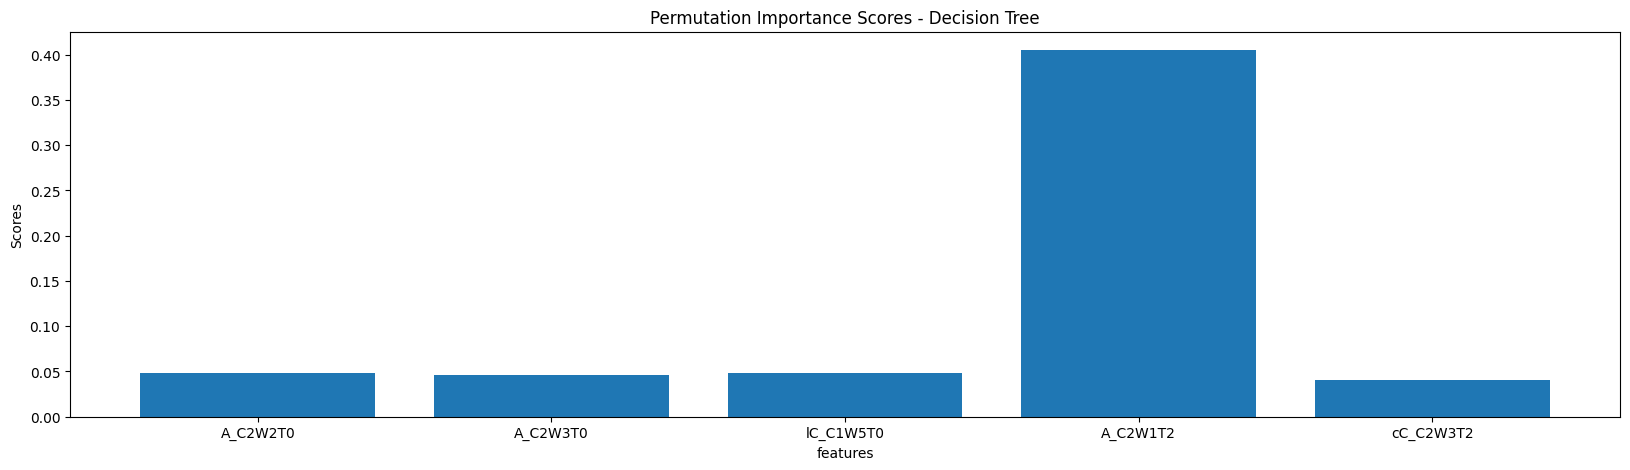

In [58]:
plt.figure(figsize=(20,5))
plt.bar(features[important_var_indices],importance_scores)
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Permutation Importance Scores - Decision Tree')
plt.show()
